# PR_8.1 Regressiemodellen in Machine Learning

## Opdracht

Great Outdoors wil graag weten hoeveel zij gaat verkopen (afhankelijke variabele) in het volgende jaar.
- Bedenk met welke onafhankelijke variabelen dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
- Pas waar nodig Dummy Encoding toe.
- Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
- Train het regressiemodel.
- Evalueer de performance van je getrainde regressiemodel.

![Splitsprocess Train- en Testdata sets](../Assets/Week%208/Splitsprocess.jpg) 

### Onafhankelijke variabelen

1. Order_Date in Order_Header
2. Order_Number in order_Header

### Afhankelijke variabele 
1. Quantity

## Implementatie

### Library Imports

In [140]:
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy
import sqlite3
import csv
import pyodbc


### Data import en samenvoeging

In [141]:
sales_con = None
crm_con = None
staff_con = None
GO_SALES_PRODUCT_FORECASTData = None
GO_SALES_INVENTORY_LEVELSData = None



try : 
        sales_con = sqlite3.connect("../Assets/Week 2/go_sales.sqlite")
        print("Connected to go_sales sqlite.")


        crm_con = sqlite3.connect("../Assets/Week 2/go_crm.sqlite")
        print("Connected to go_crm sqlite.")


        staff_con = sqlite3.connect("../Assets/Week 2/go_staff.sqlite")
        print("Connected to go_staff sqlite.")

        GO_SALES_PRODUCT_FORECASTData = pd.read_csv("../Assets/Week 2/GO_SALES_PRODUCT_FORECASTData.csv")
        print("Connected to GO_SALES_PRODUCT_FORECASTData")

        GO_SALES_INVENTORY_LEVELSData = pd.read_csv("../Assets/Week 2/GO_SALES_INVENTORY_LEVELSData.csv", header=0, index_col=False)
        print("Connected to GO_SALES_INVENTORY_LEVELSData.csv")


except sqlite3.Error as error: 
        print("Failed to read data from sqlite table", error)

DataWarehouse_con = None

try : 
        pass
except : 
        pass




Connected to go_sales sqlite.
Connected to go_crm sqlite.
Connected to go_staff sqlite.
Connected to GO_SALES_PRODUCT_FORECASTData
Connected to GO_SALES_INVENTORY_LEVELSData.csv


In [142]:
global product
product = pd.read_sql_query("SELECT * FROM {}".format("product"),sales_con)
product = product[product.columns.drop(list(product.filter(regex="TRIAL")))]

global product_type
product_type = pd.read_sql_query("SELECT * FROM {}".format("product_type"),sales_con)
product_type = product_type[product_type.columns.drop(list(product_type.filter(regex="TRIAL")))]

global product_line
product_line = pd.read_sql_query("SELECT * FROM {}".format("product_line"),sales_con)
product_line = product_line[product_line.columns.drop(list(product_line.filter(regex="TRIAL")))]

global order_header
order_header = pd.read_sql_query("SELECT * FROM {}".format("order_header"),sales_con)
order_header = order_header[order_header.columns.drop(list(order_header.filter(regex="TRIAL")))]

global order_details
order_details = pd.read_sql_query("SELECT * FROM {}".format("order_details"),sales_con)
order_details = order_details[order_details.columns.drop(list(order_details.filter(regex="TRIAL")))]

In [143]:
dataset = pd.merge(order_header, order_details, left_on="ORDER_NUMBER", how="inner", right_on="ORDER_NUMBER")
dataset = pd.merge(dataset, product, left_on="PRODUCT_NUMBER", how="inner", right_on="PRODUCT_NUMBER")



dataset = dataset.convert_dtypes()
dataset["PRODUCT_NUMBER"] = dataset["PRODUCT_NUMBER"].astype(int)
dataset["ORDER_METHOD_CODE"] = dataset["ORDER_METHOD_CODE"].astype(int)
dataset["PRODUCT_TYPE_CODE"] = dataset["PRODUCT_TYPE_CODE"].astype(int)
dataset["UNIT_COST"] = dataset["UNIT_COST"].astype(float)
dataset["UNIT_SALE_PRICE"] = dataset["UNIT_SALE_PRICE"].astype(float)

# probeer lijst van unieke retailer_names op te vragen en te mappen naar int voor in regressiemodel
retailers = pd.DataFrame(dataset["RETAILER_NAME"])
retailers = retailers.drop_duplicates()
retailers["RETAILER_ID"] = pd.factorize(retailers['RETAILER_NAME'].tolist())[0]



dataset = pd.merge(dataset, retailers, left_on="RETAILER_NAME", how="inner", right_on="RETAILER_NAME")

dataset = dataset.loc[:,["ORDER_DATE","ORDER_METHOD_CODE","PRODUCT_NUMBER","PRODUCT_TYPE_CODE","QUANTITY", "UNIT_COST","UNIT_SALE_PRICE", "RETAILER_ID"]]
dataset["YEAR"] = pd.DatetimeIndex(dataset["ORDER_DATE"]).year
dataset["MONTH"] = pd.DatetimeIndex(dataset["ORDER_DATE"]).month
dataset = dataset.drop(["ORDER_DATE"], axis=1)

# dataset = dataset.groupby(["PRODUCT_NUMBER","YEAR","MONTH"]).sum()

# dataset = dataset.loc[(dataset["YEAR"]==2020),:]
# dataset = dataset.loc[(dataset["YEAR"]==2021),:]
# dataset = dataset.loc[(dataset["YEAR"]==2022),:]

print(dataset.dtypes)
print()
print(dataset.count())

dataset = dataset.loc[(dataset["QUANTITY"]<=800),:]

display(dataset)


C:\Users\arcde\AppData\Local\Temp\ipykernel_16208\3053438187.py:16: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  retailers["RETAILER_ID"] = pd.factorize(retailers['RETAILER_NAME'].tolist())[0]


ORDER_METHOD_CODE      int32
PRODUCT_NUMBER         int32
PRODUCT_TYPE_CODE      int32
QUANTITY               Int64
UNIT_COST            float64
UNIT_SALE_PRICE      float64
RETAILER_ID            int64
YEAR                   int32
MONTH                  int32
dtype: object

ORDER_METHOD_CODE    43063
PRODUCT_NUMBER       43063
PRODUCT_TYPE_CODE    43063
QUANTITY             43063
UNIT_COST            43063
UNIT_SALE_PRICE      43063
RETAILER_ID          43063
YEAR                 43063
MONTH                43063
dtype: int64


,ORDER_METHOD_CODE,PRODUCT_NUMBER,PRODUCT_TYPE_CODE,QUANTITY,UNIT_COST,UNIT_SALE_PRICE,RETAILER_ID,YEAR,MONTH
0,7,2,1,100,9.64,11.81,0,2020,4
1,7,32,5,254,18.25,25.10,0,2020,4
2,7,35,5,114,19.67,24.82,0,2020,4
3,7,36,5,130,21.03,31.44,0,2020,4
4,7,39,5,74,42.33,61.38,0,2020,4
...,...,...,...,...,...,...,...,...,...
43058,5,52,8,64,19.00,33.25,108,2022,2
43059,5,56,8,24,9.00,15.75,108,2022,2
43060,5,57,9,40,40.00,70.00,108,2022,2
43061,5,78,13,32,79.19,94.05,108,2022,2


### One-hot encoding van onafhankelijke niet-numerieke variabelen

In [144]:
# pd.get_dummies(DATAFRAME.loc[:, [KOLOMMEN]])

### Verticaal en horizontaal snijden

In [145]:
X_dataset = dataset.drop("QUANTITY", axis=1)
Y_dataset = dataset.loc[:, ["QUANTITY"]]

# X_dataset
# Y_dataset

In [146]:
x_train, x_test, y_train, y_test = train_test_split(
    X_dataset,
    Y_dataset,
    test_size=0.15, #Percentage van de datasets dat opzij wordt gezet voor test doeleinden
    random_state=42 #zorgt ervoor dat resultaten consistent blijven. Arbitrair nummer
)
print(f"Length of x_train is {len(x_train)} \nLength of y_train is {len(y_train)}")
display(y_train)

Length of x_train is 36589 
Length of y_train is 36589


,QUANTITY
10594,12
34055,18
30852,20
3740,140
42571,8
...,...
6268,14
11287,44
38174,28
860,46


### Regressiemodel bouwen

In [157]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train, y_train)
reg_model

LinearRegression()

In [160]:
y_prediction = reg_model.predict(x_test)
display(pd.DataFrame(y_prediction))

,0
0,65.879527
1,35.803301
2,52.432910
3,53.225095
4,53.358779
...,...
6452,54.060965
6453,47.651333
6454,49.231274
6455,57.875367


In [149]:
prediction_DF = pd.DataFrame(y_prediction)
prediction_DF = prediction_DF.rename(columns= {0 : "Predicted Quantity"})

prediction_DF

,Predicted Quantity
0,65.879527
1,35.803301
2,52.432910
3,53.225095
4,53.358779
...,...
6452,54.060965
6453,47.651333
6454,49.231274
6455,57.875367


In [150]:
y_prediction_merge_test = pd.concat([y_test.reset_index()["QUANTITY"], prediction_DF], axis=1)
y_prediction_merge_test.loc[y_prediction_merge_test["Predicted Quantity"].notna(),:]
y_prediction_merge_test

,QUANTITY,Predicted Quantity
0,46,65.879527
1,12,35.803301
2,22,52.432910
3,48,53.225095
4,16,53.358779
...,...,...
6452,60,54.060965
6453,16,47.651333
6454,10,49.231274
6455,38,57.875367


#### Grafiek schetsen

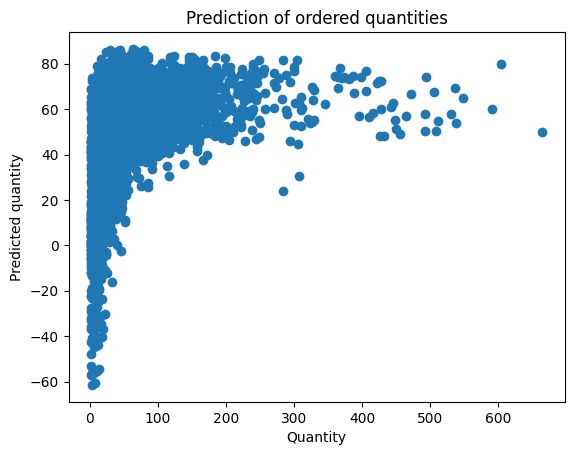

In [151]:
plt.scatter(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"])


plt.title('Prediction of ordered quantities')
plt.xlabel('Quantity')
plt.ylabel('Predicted quantity')


plt.show()

In [152]:
mean_squared_error(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"])

2764.827458808092

In [153]:
mean_absolute_error(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"])

31.848096998273398

In [162]:
numpy.sqrt(mean_squared_error(y_prediction_merge_test["QUANTITY"], y_prediction_merge_test["Predicted Quantity"]))

52.58162662763574

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
        4.000e+00, 7.000e+00, 8.000e+00, 2.000e+00, 6.000e+00, 4.000e+00,
        9.000e+00, 9.000e+00, 2.100e+01, 2.100e+01, 2.000e+01, 2.300e+01,
        4.900e+01, 6.400e+01, 6.600e+01, 8.100e+01, 1.290e+02, 1.960e+02,
        2.830e+02, 4.790e+02, 8.180e+02, 1.160e+03, 1.346e+03, 1.068e+03,
        4.580e+02, 8.600e+01]),
 array([-613.88254094, -600.20922069, -586.53590045, -572.86258021,
        -559.18925997, -545.51593973, -531.84261949, -518.16929924,
        -504.495979  , -490.82265876, -477.14933852, -463.47601828,
        -449.80269803, -436.12937779, -422.45605755, -408.78273731,
        -395.10941707, -381.43609682, -367.76277658, -354.08945634,
        -340.4161361 , -326.74281586

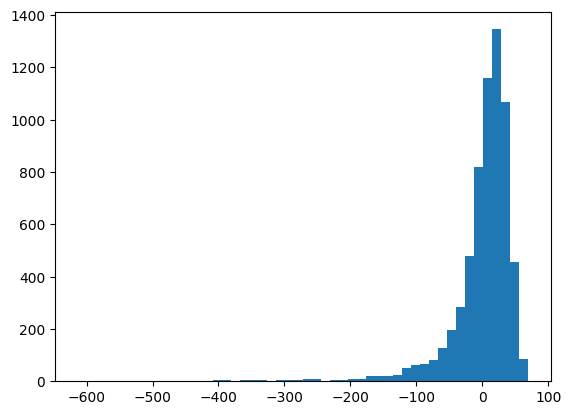

In [161]:
plt.hist(y_prediction_merge_test["Predicted Quantity"] - y_prediction_merge_test["QUANTITY"], bins=50)